**Termómetro Digital de Audiencias: Análisis de Sentimiento con IA**


> Pipeline ETL y NLP para Evaluación de Contenidos

- Se instalan las librerías necesarias para el Web Scraping (youtube-comment-downloader) y el Procesamiento de Lenguaje Natural (pysentimiento).
- Se descarga y carga en memoria del modelo Transformer (BERT) pre-entrenado en español. Esto se ejecuta una única vez para optimizar el tiempo de inferencia en análisis posteriores.

Al usar pysentimiento, esto carga modelos basados en BETO o RoBERTa-BNE (entrenados con millones de textos en español, incluyendo redes sociales), lo que significa que entiende jerga, emojis y gramática informal mucho mejor que un traductor.

In [ ]:
# Librerías
%%capture
!pip install youtube-comment-downloader pysentimiento pandas tqdm matplotlib seaborn

import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from itertools import islice
from youtube_comment_downloader import YoutubeCommentDownloader
from pysentimiento import create_analyzer
from tqdm.notebook import tqdm
from IPython.display import display, Markdown

# Estilo de gráficos profesional
plt.style.use('fivethirtyeight')

print("Cargando Modelo de IA (BERT)...")
analyzer = create_analyzer(task="sentiment", lang="es")
print("Sistema listo.")

**Función Maestra de Extracción y Análisis (ETL + NLP)**
- Flujo completo de Datos (Pipeline End-to-End).
- Conecta con la API de YouTube mediante scraping para descargar comentarios en tiempo real, limpiando el ID del video automáticamente.
- Normaliza los datos, aplica el modelo IA de clasificación de sentimiento mostrando el % de confianza* y genera un reporte gráfico ordenado por comentarios con mayor validación social (Likes).

*Es el nivel de certeza que tiene la Inteligencia Artificial sobre su propia respuesta. Es un número del 0% al 100% que indica qué tan segura está la máquina de que su clasificación (Positivo, Negativo o Neutro) es la correcta.


In [ ]:
def analizar_video_static(video_input, cantidad=50):
    """
    Función optimizada:
    - Genera reporte visual estático.
    - Elimina muestra aleatoria.
    - Muestra Top Influencers con % de Confianza de la IA.
    """

    # 1. LIMPIEZA DE ID
    video_id = video_input
    if "youtube.com" in video_id or "youtu.be" in video_id:
        if "v=" in video_id:
            video_id = video_id.split("v=")[1]
        else:
            video_id = video_id.split("/")[-1]
    video_id = video_id.split("&")[0].split("?")[0]

    print(f"\n Conectando con video ID: {video_id}...")

    # 2. SCRAPING
    downloader = YoutubeCommentDownloader()
    data_raw = []

    try:
        comments_generator = downloader.get_comments(video_id, sort_by=1)
        for comment in tqdm(islice(comments_generator, cantidad), total=cantidad, desc="Descargando"):
            data_raw.append({
                'Comentario': comment.get('text', ''),
                'Autor': comment.get('author', 'Anónimo'),
                'Likes_Raw': comment.get('votes', '0')
            })
    except Exception as e:
        print(f" Nota: {e}")

    if not data_raw:
        print(" No se encontraron datos. Verifica el ID.")
        return

    df = pd.DataFrame(data_raw)

    #  LIMPIEZA DE LIKES
    def limpiar_likes(valor):
        if not valor: return 0
        valor = str(valor).upper().replace(',', '.')
        multiplicador = 1
        if 'K' in valor:
            multiplicador = 1000
            valor = valor.replace('K', '')
        elif 'M' in valor:
            multiplicador = 1000000
            valor = valor.replace('M', '')
        try:
            return int(float(valor) * multiplicador)
        except:
            return 0

    df['Likes'] = df['Likes_Raw'].apply(limpiar_likes)
    # -------------------------

    # 3. PROCESAMIENTO IA
    def predecir(texto):
        if not isinstance(texto, str) or len(texto) < 2: return "NEU", 0.0
        try:
            pred = analyzer.predict(texto)
            return pred.output, pred.probas[pred.output]
        except:
            return "NEU", 0.0

    tqdm.pandas(desc="Analizando")
    df[['Sentimiento', 'Confianza']] = df['Comentario'].progress_apply(
        lambda x: pd.Series(predecir(x))
    )

    mapa = {'POS': 'Positivo', 'NEG': 'Negativo', 'NEU': 'Neutro'}
    df['Sentimiento_Label'] = df['Sentimiento'].map(mapa)

    # 4. VISUALIZACIÓN
    display(Markdown(f"### Reporte de Audiencia: {video_id}"))

    color_map = {'Negativo': '#D32F2F', 'Neutro': '#9E9E9E', 'Positivo': '#388E3C'}
    conteo = df['Sentimiento_Label'].value_counts()

    # Gráficos
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 6))

    colores_pie = [color_map.get(label, '#9E9E9E') for label in conteo.index]
    ax1.pie(conteo, labels=conteo.index, autopct='%1.1f%%', startangle=90, colors=colores_pie)
    ax1.set_title('Distribución de Opiniones', fontsize=14)

    sns.countplot(x='Sentimiento_Label', data=df, hue='Sentimiento_Label',
                  palette=color_map, ax=ax2, legend=False)
    ax2.set_title('Volumen por Sentimiento', fontsize=14)
    ax2.set_xlabel('')

    plt.tight_layout()
    plt.show()

    # Función de estilo
    def color_filas(row):
        c = '#ffcdd2' if row['Sentimiento_Label'] == 'Negativo' else \
            '#c8e6c9' if row['Sentimiento_Label'] == 'Positivo' else '#f5f5f5'
        return [f'background-color: {c}; color: black'] * len(row)

    # 5. TABLA: TOP 10 INFLUENCERS (LIKES + CONFIANZA)
    display(Markdown("### Top 10 Comentarios Más Apoyados (Likes)"))
    top_likes = df.sort_values('Likes', ascending=False).head(10).copy()

    # Mostrar Likes, Sentimiento, CONFIANZA y Comentario
    display(top_likes[['Likes', 'Sentimiento_Label', 'Confianza', 'Comentario']]
            .style.apply(color_filas, axis=1)
            .format({
                'Likes': '{:,}',       # Ejemplo: 1,200
                'Confianza': '{:.1%}'  # Ejemplo: 98.5%
            }))

**Zona de Ejecución y Reporte**
- se ingresa el ID o enlace del video objetivo. Al ejecutar, se invoca la función maestra que procesa los datos y despliega el Dashboard de Audiencia con las métricas de sentimiento y los comentarios destacados.


 Conectando con video ID: tLrJ9Dy652U...


Descargando:   0%|          | 0/500 [00:00<?, ?it/s]

Analizando:   0%|          | 0/500 [00:00<?, ?it/s]

### Reporte de Audiencia: tLrJ9Dy652U

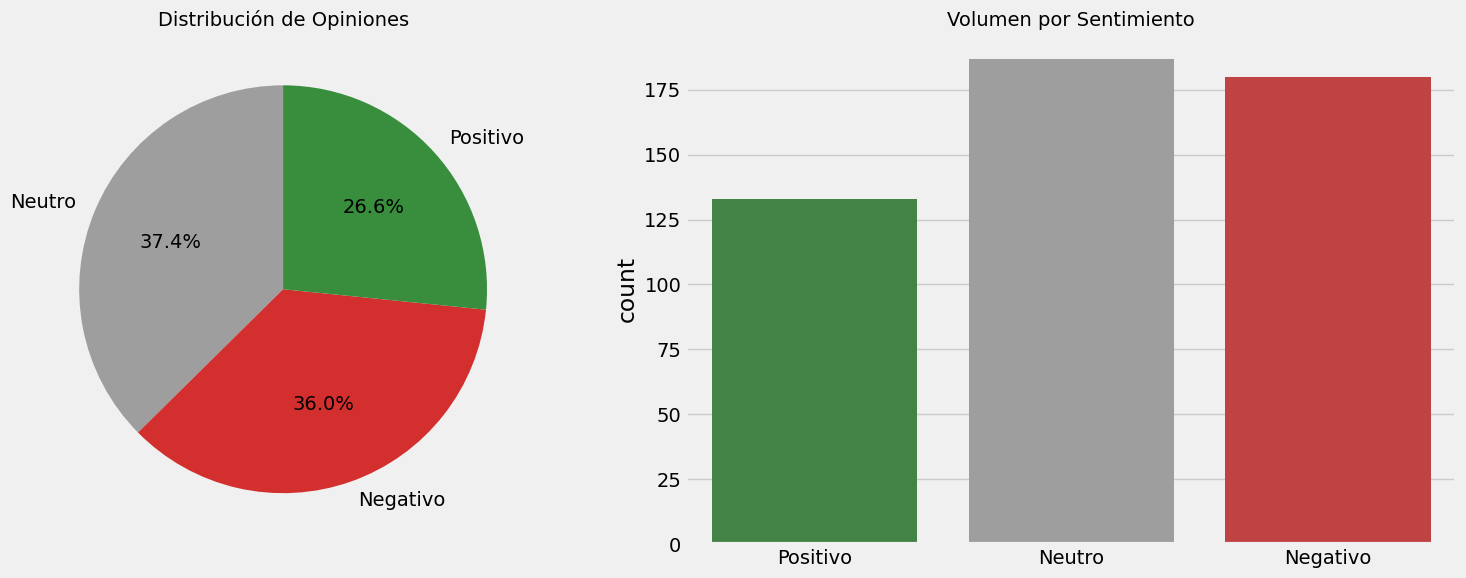

### Top 10 Comentarios Más Apoyados (Likes)

,Likes,Sentimiento_Label,Confianza,Comentario
356,121,Negativo,96.2%,"¡¡BASTA de usar MAL el verbo ""HABER""!! Internet se ha vuelto insufrible a base de ese paletismo que yo ya NO veía desde los 80. ¡¡ ""HABÍAN"" NO EXISTEEEE!!!! (excepto como auxiliar). Se dice ""Había 10 niños"", ""Hubo 10 niños"", NO ""Habían"", o ""Hubieron""."
348,116,Neutro,79.0%,"Hola, soy Antropólga en México. Según nuestros estudios, es cierto que el hombre no está diseñado para dormir toda la noche. En los tiempos Prehistóricos, se tenían que turnar los humanos para estar en guardia toda la noche. Entonces, se supone que se dividían la noche, de manera que uno dormía hasta las 3am y se levantaba para que el otro pudiera dormir, lo que es una gran ""coincidencia"", es que la mayoría de las personas se despiertan a las 3am. Saludos, muy interesante su programa."
455,57,Positivo,78.5%,Que raro ver al señor escocés en otro plano que no sea de frente a la cámara!!! Jajaja grande Escoces
291,39,Positivo,67.6%,"Soy gran seguidor de Esco desde hace años y valoro mucho su trabajo. Sin embargo, tengo una sugerencia constructiva: cuando se aborda un tema de Historia, lo ideal sería contar con historiadores de formación, igual que se hace con médicos o físicos en sus respectivos campos. Esto no quita valor al contenido actual, pero sin duda sumaría autoridad y profundidad académica"
353,32,Neutro,57.6%,"Fe de erratas, donde dice mar Adriatico congelado, es mar Baltico."
269,32,Positivo,96.3%,Cuando ví la duración del video no daba un duro por verlo hasta el final...me lo comí entero y muy a gusto....enhorabuena a los dos.
206,28,Positivo,93.5%,"Sería excelente confrontar esta información con historiadores expertos, porque es diferente la visión de un gamer, que la visión de una persona formada en ciencias sociales. De todas maneras, muy entretenido."
451,18,Positivo,97.1%,"Que bueno verlo a escocés hablando de historia y en otro formato, que genial. Lo de la mini era glacial creo q es un fenómeno que se llama mínimo de mauder"
393,16,Neutro,68.7%,"​ @LuisGracia-c7j Nada nuevo: Ellos habían ido a investigar el uso de ""habían"" aunque no habían leído previamente este comentario. Menos mal que había (y no habían) aún personas que intentan hacer un uso correcto del verbo haber. 😂😂"
388,16,Negativo,75.9%,Fallo típico entre las personas que también hablan catalán.


In [ ]:
# Cambiar ID video y ejecutar análisis

NUEVO_VIDEO_ID = 'tLrJ9Dy652U'

analizar_video_static(NUEVO_VIDEO_ID, cantidad=500)